## run a field-level IMNN on simulations with noise

In [1]:
cd imnn_scripts/

/home/makinen/venvs/lemur/lib64/python3.11/site-packages/IPython/core/magics/osm.py:417: UserWarning: using dhist requires you to install the `pickleshare` library.
  self.shell.db['dhist'] = compress_dhist(dhist)[-100:]


/home/makinen/repositories/wl-sbi/imnn_scripts


In [2]:
import math
import jax
import jax.numpy as jnp
import jax_cosmo as jc
import optax
import matplotlib.pyplot as plt
from functools import partial
import flax.linen as nn

import jax.random as jr

import cloudpickle as pickle


np = jnp

from imnns import *
from imnn_update import *

def save_obj(obj, name ):
    with open(name + '.pkl', 'wb') as f:
        pickle.dump(obj, f)
        
def load_obj(name):
    with open(name, 'rb') as f:
        return pickle.load(f)


%load_ext autoreload
%autoreload 2

### pull in simulations and compute MOPED for Cls WITH NOISE

In [3]:
z_means_analysis = jnp.array([0.5, 0.75, 1.0, 1.25]) #jnp.array([0.5, 1.0, 1.5, 2.0])

def indices_vector(num_tomo):
   indices = []
   cc = 0
   for catA in range(0,num_tomo,1):
      for catB in range(catA,num_tomo,1):
        indices.append([catA, catB])
        cc += 1
   return indices

L = 250
cl_cut = -1 #13 #6 # 13
skip = 12 #2
num_tomo = 4
Lgrid = (L, L, 4000)
Nmesh = (128,128,512)
num_bins = jnp.ones(Nmesh[0]//2)[:cl_cut:skip].shape[0]
chi_grid = (jnp.arange(Nmesh[2]) + 0.5) * Lgrid[2] / Nmesh[2]
chi_source = chi_grid[-1]
indices = jnp.array(indices_vector(num_tomo))
cl_shape = indices.shape[0] * cl_cut

# NO NOISE FOR NOW
NOISEAMP = 0.25 #0.25


do_noise = True

def compute_variance_catalog(zmean=z_means_analysis):

    N0 = Nmesh[0]
    N1 = Nmesh[1]
    N2 = Nmesh[2]
    L0 = Lgrid[0]
    L1 = Lgrid[1]
    L2 = Lgrid[2]
    
    Ncat = 4

    cosmo = jc.Planck15(Omega_c=0.3, sigma8=0.8) # no sigma8-dependence 
    rms = 0.3 / 2. # from review (corrected w Hall comment)
    a = 1. / (1. + zmean)
    dist = jc.background.radial_comoving_distance(cosmo, a, log10_amin=-3, steps=256)
    angle = 2. * jnp.arctan((L0/N0/2) / dist)
    arcmin_angle = angle * 180. / np.pi * 60.
    arcmin2_pix = arcmin_angle**2
    sources = 30. / Ncat * arcmin2_pix # from Euclid
    return rms**2 / sources

noisevars = compute_variance_catalog()

noisevars

/home/makinen/venvs/lemur/lib64/python3.11/site-packages/jax/_src/numpy/array_methods.py:66: UserWarning: Explicitly requested dtype <class 'jax.numpy.int64'> requested in astype is not available, and will be truncated to dtype int32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/google/jax#current-gotchas for more.
  return lax_numpy.astype(arr, dtype)


Array([0.00011255, 0.00021868, 0.00033681, 0.00045853], dtype=float32)

In [4]:
@jax.jit
def rotate_sim(k, sim):
    k = k % 4

    condition1 = (k > 0)
    condition2 = (k > 1)
    condition3 = (k > 2)
    condition4 = (k == 3)

    # if k == 0:
    def kzero(k):
        return sim
    # if k == 1:
    def kone(k):
        return jnp.rot90(sim, k=1, axes=(1,2))
    # if k == 2:
    def ktwo(k):
        return jnp.rot90(sim, k=2, axes=(1,2))
    def kthree(k):
        return jnp.rot90(sim, k=3, axes=(1,2))

    # if >2, use kthree, else use ktwo
    def biggerthantwo(k):
        return jax.lax.cond(condition3, true_fun=kthree, false_fun=ktwo, operand=k)

    # if > 1, return biggerthan2, else use kone
    def biggerthanone(k):
        return jax.lax.cond(condition2, true_fun=biggerthantwo, false_fun=kone, operand=k)

    # if >0 , return biggerthan1, else use kzero
    sim = jax.lax.cond(condition1, true_fun=biggerthanone, false_fun=kzero, operand=k)

    return sim

@partial(jax.jit, static_argnums=(3,4))
def noise_simulator(key, sim, noisescale=NOISEAMP, rot=True, noisevars=noisevars):
    key1,key2 = jr.split(key)
    # do rotations of simulations
    k = jr.choice(key1, jnp.array([0,1,2,3]), shape=())
    if rot:
     sim = rotate_sim(k, sim)
    else:
     sim = sim

    # now add noise
    # this generates white noise across all pixels and then increases the amplitude
    sim += (jr.normal(key2, shape=(4,N,N)) * noisescale * jnp.sqrt(noisevars).reshape(4,1,1))
    return sim

In [5]:
from lemur import analysis, background, cosmology, limber, simulate, plot, utils, constants
from moped import *


def get_spec(index, tomo_data, key):
    
    if do_noise:
        tomo_data = noise_simulator(key, tomo_data)
    
    return analysis.compute_auto_cross_angular_power_spectrum(tomo_data[index[0]], tomo_data[index[1]],
                                                chi_source, Lgrid[0])[1][:cl_cut:skip]

def cls_allbins(tomo_data, key):
    gps = lambda i: get_spec(i, tomo_data, key)
    return jax.vmap(gps)(indices)



def get_spec_nonoise(index, tomo_data):

    return analysis.compute_auto_cross_angular_power_spectrum(tomo_data[index[0]], tomo_data[index[1]],
                                                chi_source, Lgrid[0])[1][:cl_cut:skip]

def cls_allbins_nonoise(tomo_data):
    gps = lambda i: get_spec_nonoise(i, tomo_data)
    return jax.vmap(gps)(indices)


In [6]:
from tqdm import tqdm as tq

### ------------- IMNN PARAMETERS -------------
θ_fid = jnp.array([0.5, 1.162]) #jnp.array([0.5, 0.67])
δθ = 2*jnp.array([0.0115, 0.02])

θ_der = (θ_fid + jnp.einsum("i,jk->ijk", jnp.array([-1., 1.]), jnp.diag(δθ) / 2.)).reshape((-1, 2))


n_summaries = 2

n_s = 1500
n_d = 750 // 2 #125

n_params = 2
n_summaries = n_params
print(θ_der)

N = 128
L = Lgrid[0]
lpt_order = 2
outdir = "/data101/makinen/lemur_sims/first_analysis/"


fid = jnp.load(outdir + "fid_S8_L_%d_N_%d_Nz_512_LPT%d_Om_%d_s8_%d.npy"%(L, N, lpt_order, θ_fid[0]*10, θ_fid[1]*10)) 
#jnp.load(outdir + "fid_tomo_L_%d_N_%d_Nz_512_LPT%d.npy"%(L, N, lpt_order))
derv = jnp.load(outdir + "derv_S8_L_%d_N_%d_Nz_512_LPT%d_Om_%d_s8_%d.npy"%(L, N, lpt_order, θ_fid[0]*10, θ_fid[1]*10))[:n_d*2]
#jnp.load(outdir + "derv_tomo_L_%d_N_%d_Nz_512_LPT%d.npy"%(L, N, lpt_order))

key = jr.PRNGKey(7777)
key,rng = jr.split(key)

fid_keys = jr.split(key, num=2*n_s)
derv_keys = jr.split(rng, num=2*n_d)
derv_keys = jnp.repeat(derv_keys, θ_der.shape[0], axis=0) # flattened repeated keys


# ----- DO MOPED WITH ALL SIMS (NOISEFREE) -----
fid_cls = []
batch = 50
for i in tq(range(fid.shape[0] // batch)):
    f_ = jax.vmap(cls_allbins)(fid[i*batch:(i+1)*batch], fid_keys[i*batch:(i+1)*batch]).reshape(-1, len(indices)*(num_bins))
    fid_cls.append(f_)

fid_cls = jnp.concatenate(fid_cls)

derv_cls = []
batch = 50
for i in tq(range(n_d*2*2*n_params // batch)):
    d_  = jax.vmap(cls_allbins)(derv.reshape(-1, num_tomo, Nmesh[0], Nmesh[1])[i*batch:(i+1)*batch], 
                               derv_keys[i*batch:(i+1)*batch])
    derv_cls.append(d_)

derv_cls = jnp.concatenate(derv_cls).reshape(n_d*2, 2, n_params, len(indices)*(num_bins))
# ----- -----

cl_shape = derv_cls.shape[-1]
# now initialise MOPED object


[[0.4885    1.162    ]
 [0.5       1.142    ]
 [0.5115    1.162    ]
 [0.5       1.1819999]]


100%|██████████| 60/60 [00:00<00:00, 70.92it/s]


In [7]:
derv_cls.shape

(750, 2, 2, 60)

In [8]:
ell,clsfoo = analysis.compute_auto_cross_angular_power_spectrum(fid[59, 0], fid[59, 0], chi_source, Lgrid[0])
np.argmin((ell - 1000)**2)

Array(9, dtype=int32)

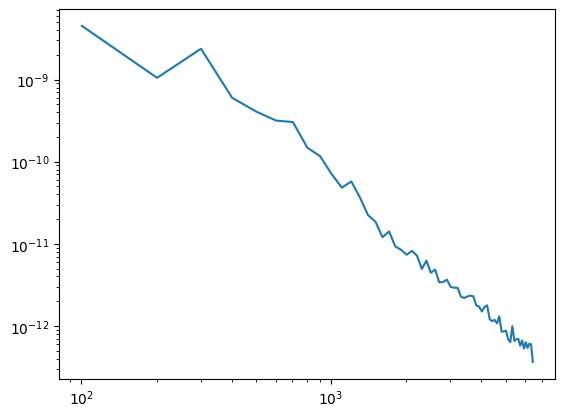

In [9]:
plt.loglog(ell, clsfoo)

In [10]:
mymoped = MOPED(n_param=2, n_d=n_d*2, n_s=n_s*2, 
                input_shape=fid_cls[0].shape, 
                fiducial=fid_cls, 
                derivatives=derv_cls, 
                δθ=δθ, 
                θ_fid=θ_fid
               )

moped_summs = mymoped.compress(fid_cls)

# next we're going to do a second moped compression to get the derivatives into a smaller space.
# you can check to see that the fisher is the same for both !
mymoped2 = MOPED(
                n_param=2, n_d=n_d*2, n_s=n_s*2, 
                input_shape=(2,), 
                fiducial=mymoped.compress(fid_cls), 
                derivatives=mymoped.compress(derv_cls.reshape((-1,) + fid_cls[0].shape)).reshape(n_d*2, 2, 2, 2), 
                δθ=δθ, 
                θ_fid=θ_fid
)

print("moped 2 F:", mymoped2.F, "moped 1 F:", mymoped.F)
print("moped 2 F:", jnp.linalg.det(mymoped2.F), "moped 1 F:", jnp.linalg.det(mymoped.F))

moped_statistic = dict(
        n_t = 2,
        mean_derivatives = mymoped2.mu_dervs,
        covariance = mymoped.invF,
        Fisher = mymoped.F,
        fid_summaries=mymoped.compress(fid_cls),
)

moped 2 F: [[2731.858    619.3629 ]
 [ 619.3629   268.14893]] moped 1 F: [[2731.8645   619.3556 ]
 [ 619.36365  268.15085]]
moped 2 F: 348934.34 moped 1 F: 348945.47


In [11]:
# split into train and val sets

val_fid = fid[n_s:]
val_derv = derv[n_d:]

fid = fid[:n_s]
derv = derv[:n_d]

(fid.shape, derv.shape), (val_fid.shape, val_derv.shape)

(((1500, 4, 128, 128), (375, 2, 2, 4, 128, 128)),
 ((1500, 4, 128, 128), (375, 2, 2, 4, 128, 128)))

In [12]:
fid[59].reshape(4, -1).std(1)

Array([0.00715469, 0.00939166, 0.01138024, 0.01243957], dtype=float32)

In [13]:
np.sqrt(noisevars) * 10

Array([0.10609071, 0.14787903, 0.18352462, 0.21413231], dtype=float32)

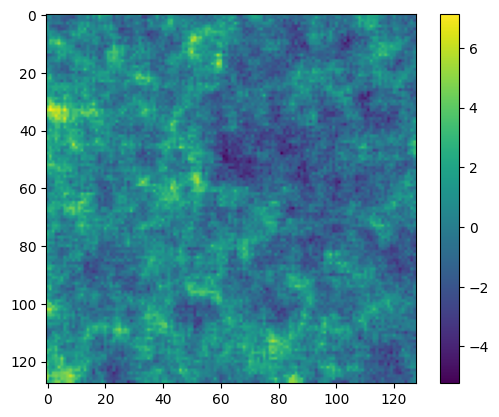

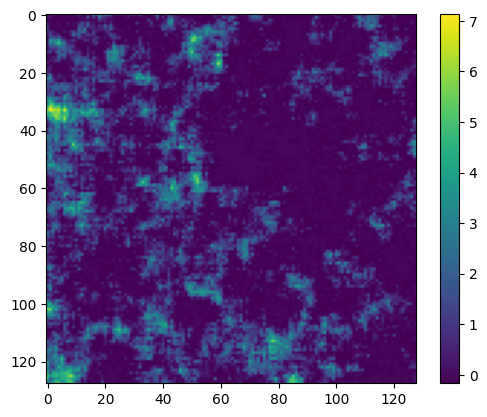

In [14]:
q = noise_simulator(key, fid[34])[1, ...] * 150
plt.imshow((q))
plt.colorbar()
plt.show()
plt.imshow(nn.gelu(q) )
plt.colorbar()
plt.show()

# NPE code

In [15]:
from NPE import npe
from NPE.multipole_cnn import MultipoleConv
from NPE.multipole_cnn_factory import MultipoleCNNFactory

In [16]:


factory = MultipoleCNNFactory(kernel_shape=(5,5),
                              polynomial_degrees=[0, 1, 2],
                              num_input_filters=1,
                              output_filters=None)

cnn_model = factory.build_cnn_model()

npe = cnn_model

dummy_input = jax.random.normal(key, shape=(32,32)) #.reshape([5, 5])
key = jax.random.PRNGKey(42)
init_model_params = npe.init(key, dummy_input)

In [200]:
nn.Conv

flax.linen.linear.Conv

In [201]:
dummy_input.shape

(32, 32)

In [202]:
init_model_params['params']['kernel_weights'].shape

(51, 1)

In [203]:
outs = npe.apply(init_model_params, dummy_input)

In [204]:
outs.shape

(6, 32, 32)

In [205]:
cnn_model.multipole_kernels.shape

(51, 5, 5, 6)

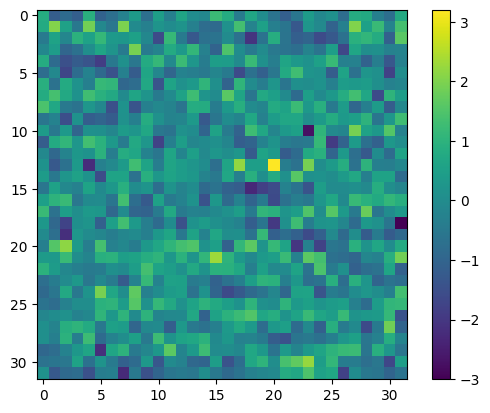

In [206]:
plt.imshow(outs[5, :, :])
plt.colorbar()

In [207]:
pole_layer = MultipoleCNNFactory(kernel_shape=(5,5),
              polynomial_degrees=[0, 1, 2],
              num_input_filters=1,
              output_filters=None).build_cnn_model()

In [209]:
pole_layer.init

<bound method Module.init of MultipoleConv(
    # attributes
    num_output_filters = Array(6, dtype=int32)
    num_params = Array(51, dtype=int32)
    multipole_kernels = array([[[[0., 0., 0., 0., 0., 0.],
             [0., 0., 0., 0., 0., 0.],
             [0., 0., 0., 0., 0., 0.],
             [0., 0., 0., 0., 0., 0.],
             [0., 0., 0., 0., 0., 0.]],
    
            [[0., 0., 0., 0., 0., 0.],
             [0., 0., 0., 0., 0., 0.],
             [0., 0., 0., 0., 0., 0.],
             [0., 0., 0., 0., 0., 0.],
             [0., 0., 0., 0., 0., 0.]],
    
            [[0., 0., 0., 0., 0., 0.],
             [0., 0., 0., 0., 0., 0.],
             [1., 0., 0., 0., 0., 0.],
             [0., 0., 0., 0., 0., 0.],
             [0., 0., 0., 0., 0., 0.]],
    
            [[0., 0., 0., 0., 0., 0.],
             [0., 0., 0., 0., 0., 0.],
             [0., 0., 0., 0., 0., 0.],
             [0., 0., 0., 0., 0., 0.],
             [0., 0., 0., 0., 0., 0.]],
    
            [[0., 0., 0., 0.

## network code

In [17]:
from typing import Any, Callable, Sequence, Optional, Union
from flax.core import freeze, unfreeze
import flax.linen as nn

import jax
import jax.numpy as jnp

Array = Any

@jax.jit
def almost_leaky(x: Array) -> Array:
  r"""Almost Leaky rectified linear unit activation function.

  Computes the element-wise function:

  .. math::
    \mathrm{almost\_leaky}(x) = \begin{cases}
      x, & x \leq -1\\
      - |x|^3/3, & -1 \leq x < 1\\
      3x & x > 1
    \end{cases}

  Args:
    x : input array
  """
  return jnp.where(x < -1, x, jnp.where((x < 1), ((-(jnp.abs(x)**3) / 3) + x*(x+2) + (1/3)), 3*x)) / 3.5



def next_power_of_two(number):
    # Returns next power of two following 'number'
    return math.ceil(math.log2(number))

def conv_outs(W, K=2, P=0, S=3):
    return math.ceil(((W - K + (2*P)) / S )+1)

#@jax.jit
def get_padding(arraylen):
    """
    helper function to pad uneven strided outputs
    """
    
    next_power = next_power_of_two(arraylen)
    deficit = int(math.pow(2, next_power) - arraylen) # how much extra to pad
    
    # but we want to pad both sides of a given axis, so return a tuple here
    
    left = deficit // 2
    right = left + (deficit % 2)
    
    return (left, right)


class InceptStride(nn.Module):
    """Inception block submodule"""
    filters: Sequence[int]
    pad_shape: int
    act: Callable = almost_leaky
    do_1x1: bool = True
    do_4x4: bool = True

    @nn.compact
    def __call__(self, x):

            
        # 2x2 stride
        x2 = nn.Conv(features=self.filters[0], kernel_size=(2,2), strides=(2,2), padding="CIRCULAR")(x)
        x2 = self.act(x2)
        x2 = nn.Conv(features=self.filters[0], kernel_size=(2,2), strides=(1,1), padding="CIRCULAR")(x2)
        x2 = self.act(x2)

        # 3x3 stride
        x3 = nn.Conv(features=self.filters[1], kernel_size=(2,2), strides=(3,3), padding="CIRCULAR")(x)
        x3 = self.act(x3)
        x3 = nn.Conv(features=self.filters[1], kernel_size=(2,2), strides=(1,1), padding="CIRCULAR")(x3)
        x3 = self.act(x3)

        # 4x4 stride
        if self.do_4x4:
            x4 = nn.Conv(features=self.filters[1], kernel_size=(2,2), strides=(4,4), padding="CIRCULAR")(x)
            x4 = self.act(x4)
            x4 = nn.Conv(features=self.filters[1], kernel_size=(2,2), strides=(1,1), padding="CIRCULAR")(x4)
            x4 = self.act(x4)

        
        # now pad the 3x3 and concatenate it to the 2x2 stride
        x3shape = conv_outs(W=self.pad_shape)
        pads = get_padding(x3shape)
        
        x3 = jnp.pad(x3, pad_width=(pads, pads, (0,0),), mode="wrap")
        x2 = jnp.concatenate([x2, x3], -1)

        # run another conv for the concated versions
        x2 = nn.Conv(features=self.filters[0], kernel_size=(2,2), strides=(1,1), padding="CIRCULAR")(x2)
        x2 = self.act(x2)
        

        # optional no stride embedding
        if self.do_1x1:
            x1 = nn.Conv(features=self.filters[2], kernel_size=(2,2), strides=(1,1), padding="CIRCULAR")(x)
            x1 = self.act(x1)
            x1 = nn.Conv(features=self.filters[2], kernel_size=(2,2), strides=(1,1), padding="CIRCULAR")(x1)
            x1 = self.act(x1)

            return x1, x2, x4

        elif self.do_4x4:
            return x2, x4

        else:
            return x2



class InceptNet(nn.Module):
    """An incept net architecture"""
    filters: Sequence[int]
    #mlp_features: Sequence[int]
    multipole_cnn1: MultipoleConv
    multipole_cnn2: MultipoleConv
    multipole_cnn3: MultipoleConv
    multipole_cnn4: MultipoleConv
    div_factor: float = 0.02
    n_outs: int = 1
    act: Callable = almost_leaky

    
    @nn.compact
    def __call__(self, x):

        filters = self.filters

        # add in Cls information
        cls_summs = cls_allbins_nonoise(jax.lax.stop_gradient(x)).reshape(-1, cl_shape)
        cls_summs = mymoped.compress(jax.lax.stop_gradient(cls_summs)).reshape(-1) # moped compress
        #cls_summs = jnp.log(jax.lax.stop_gradient(cls_summs)) + 22

        # do field-level net
        x = jnp.transpose(x, (1, 2, 0))

        x *= 150.0 #/= 0.02 #np.sqrt(noisevars)
        #x = x[..., jnp.newaxis] # expand dims for 3D conv

        # first pass to NPE layer
        x1 = self.multipole_cnn1(x[..., 0]).T
        x2 = self.multipole_cnn2(x[..., 1]).T
        x3 = self.multipole_cnn3(x[..., 2]).T
        x4 = self.multipole_cnn4(x[..., 3]).T

        # stack in filter dimension
        x = jnp.concatenate([x1, x2, x3, x4], -1)

        #print(x.shape)
        
        # create a tree of incept blocks
        #x_1_128, x_1_64, x_1_32 = InceptStride(filters=filters, pad_shape=128, act=self.act, do_1x1=True)(x)

        # concatenate the two 128x128 arrays
        #x_1_128 = x #jnp.concatenate([x, x_1_128], -1)
        #x_1_128 = jnp.concatenate([x, x_1_128], -1)

        # now act on the first 128x128 embedding
        x_1_64, x_1_32 = InceptStride(filters=filters, pad_shape=128, act=self.act, do_1x1=False)(x)

        # now concatenate the first and second sets of outputs
        #x_1_64 = jnp.concatenate([x_1_64, x_2_64], -1)
        #x_1_32 = jnp.concatenate([x_1_32, x_2_32], -1)

        # continue along the tree (no stride-1 this time)
        x_2_32, x_2_16 = InceptStride(filters=filters, pad_shape=64, act=self.act, do_1x1=False)(x_1_64)

        # now concatenate the remaining 32x32 arrays
        x_2_32 = jnp.concatenate([x_1_32, x_2_32], -1)

        # now cut down to 16x16
        x_3_16, x_2_8 = InceptStride(filters=filters, pad_shape=32, act=self.act, do_1x1=False)(x_2_32)

        # concatenate the remaining 16x16 array
        x_3_16 = jnp.concatenate([x_2_16, x_3_16], -1)

        # now cut down to 8x8
        x_3_8, x_2_4 = InceptStride(filters=filters, pad_shape=16, act=self.act, do_1x1=False)(x_3_16)

        # concatenate the 8x8s
        x_3_8 = jnp.concatenate([x_2_8, x_3_8], -1)

        # cut down to 2 and then downconv out
        x_3_4, x_2_2 = InceptStride(filters=filters, pad_shape=8, act=self.act, do_1x1=False)(x_3_8)

        # concatenate the 4x4s
        x_3_4 = jnp.concatenate([x_2_4, x_3_4], -1)

        # down to 1x1
        x_3_2 = InceptStride(filters=filters, act=self.act, pad_shape=4, do_1x1=False, do_4x4=False)(x_3_4)

        # concatenate the 2x2s
        x = jnp.concatenate([x_2_2, x_3_2], -1) # output should be (1,1, filters)

        x = nn.Conv(features=filters[0], kernel_size=(2,2), strides=(2,2), padding='CIRCULAR')(x)
        x = self.act(x)

        #print(x.shape)

        # conv or sum everything and send it out
        x = x.reshape(-1, 1)
        #print(x.shape)
        x = nn.Conv(features=filters[0], kernel_size=(5,))(x)
        x = self.act(x)
        x = nn.Conv(features=filters[0], kernel_size=(5,))(x)
        x = self.act(x)
        x = nn.Conv(features=self.n_outs, kernel_size=(1,))(x)
        x = self.act(x)
        #x = nn.Conv(features=self.n_outs, kernel_size=(1,))(x.reshape(1, -1)).reshape(-1)

        x = nn.Conv(features=2, kernel_size=(1,))(x.reshape(1, -1))

        x = jnp.linalg.inv(nn.softplus(x[:, :1])) @ x[:, 1:]
        
        x = x.reshape(-1)
        
        #x = nn.Conv(features=self.n_outs, kernel_size=(1,))(x)
        #x = x.reshape(-1)
        #x = x.sum(keepdims=True)

        #print(x.shape)
        #x = nn.Dense(50)(x)
        #x = self.act(x)
        #x = nn.Dense(self.n_outs)(x).reshape(-1)

        return jnp.concatenate([cls_summs.reshape(-1), x])



In [398]:
MultipoleCNNFactory(kernel_shape=(5,5),
             polynomial_degrees=[0,1,2],
             num_input_filters=1,
             output_filters=None).build_cnn_model()

MultipoleConv(
    # attributes
    num_output_filters = Array(6, dtype=int32)
    num_params = Array(51, dtype=int32)
    multipole_kernels = array([[[[0., 0., 0., 0., 0., 0.],
             [0., 0., 0., 0., 0., 0.],
             [0., 0., 0., 0., 0., 0.],
             [0., 0., 0., 0., 0., 0.],
             [0., 0., 0., 0., 0., 0.]],
    
            [[0., 0., 0., 0., 0., 0.],
             [0., 0., 0., 0., 0., 0.],
             [0., 0., 0., 0., 0., 0.],
             [0., 0., 0., 0., 0., 0.],
             [0., 0., 0., 0., 0., 0.]],
    
            [[0., 0., 0., 0., 0., 0.],
             [0., 0., 0., 0., 0., 0.],
             [1., 0., 0., 0., 0., 0.],
             [0., 0., 0., 0., 0., 0.],
             [0., 0., 0., 0., 0., 0.]],
    
            [[0., 0., 0., 0., 0., 0.],
             [0., 0., 0., 0., 0., 0.],
             [0., 0., 0., 0., 0., 0.],
             [0., 0., 0., 0., 0., 0.],
             [0., 0., 0., 0., 0., 0.]],
    
            [[0., 0., 0., 0., 0., 0.],
             [0., 

In [18]:
#model = nn.Conv(features=5, kernel_size=(2,2), strides=3, padding="CIRCULAR")
#model = InceptNet(filters=[5,5,20])

pole_layer = MultipoleCNNFactory(kernel_shape=(3,3),
             polynomial_degrees=[0, 1],
             num_input_filters=1,
             output_filters=None)


model = InceptNet(filters=[5,5,5], 
                  multipole_cnn1=pole_layer.build_cnn_model(),
                  multipole_cnn2=pole_layer.build_cnn_model(), 
                  multipole_cnn3=pole_layer.build_cnn_model(), 
                  multipole_cnn4=pole_layer.build_cnn_model(), 
                  act=nn.swish, n_outs=1) # nn.swish
w = model.init(jr.PRNGKey(44), jnp.zeros((4, N, N)))

x = model.apply(w, fid[0])

x

Array([ 3.2510474e-01,  8.5472071e-01, -3.1875563e-04], dtype=float32)

In [19]:
jnp.linalg.inv(jnp.ones((1,1)))

Array([[1.]], dtype=float32)

In [20]:
filters = (8,32,32,8)

#model = InceptNet(filters=[5,5,5], multipole_cnn=pole_layer, act=nn.swish, n_outs=1) # nn.swish

lr_schedule = optax.exponential_decay(init_value=1e-4, 
                        transition_begin=80,
                        transition_steps=150, 
                        decay_rate=0.5, 
                        end_value=1e-5
                       )


optimiser = optax.adam(learning_rate=5e-5) # 5e-5

#optimiser = optax.adam(learning_rate=5e-5) # 5e-5


model_key = jr.PRNGKey(44)
key = jr.PRNGKey(55)
rng, key = jr.split(key)
input_shape = (4, N, N)


# moped_statistic_long = dict(
#         n_t = derv_cls.shape[-1],
#         mean_derivatives = mymoped.mu_dervs,
#         covariance = mymoped.C,
#         Fisher = mymoped.F,
#         fid_summaries=fid_cls,
# )


# brute force method now

IMNN =  NoiseNumericalGradientIMNN(
    n_s=n_s, n_d=n_d, n_params=n_params, n_summaries=3,
    input_shape=input_shape, θ_fid=θ_fid, δθ=δθ, model=model,
    optimiser=optimiser, key_or_state=jnp.array(model_key),
    noise_simulator=(lambda rng, d: noise_simulator(
           rng, d, noisescale=NOISEAMP, rot=True)),
    fiducial=val_fid, 
    derivative=val_derv,
    validation_fiducial=fid,
    validation_derivative=derv,
    existing_statistic=moped_statistic,
    no_invC=True, # True
)

In [379]:
3*3

9

In [380]:
import gc
gc.collect()

5703

In [193]:
IMNN.set_F_statistics(IMNN.w, key)

In [194]:
IMNN.F, mymoped.F

(Array([[2731.1912 ,  645.2302 ],
        [ 645.2301 ,  271.83078]], dtype=float32),
 Array([[2731.8274 ,  619.3528 ],
        [ 619.36334,  268.14944]], dtype=float32))

In [106]:
IMNN.F, mymoped.F

(Array([[2731.0884 ,  644.3771 ],
        [ 644.37714,  270.29996]], dtype=float32),
 Array([[2731.8271 ,  619.3432 ],
        [ 619.36334,  268.1493 ]], dtype=float32))

In [107]:
jnp.linalg.det(mymoped.F), jnp.linalg.det(IMNN.F) # 731959.94

(Array(348939.03, dtype=float32), Array(322991.22, dtype=float32))

In [108]:
moped_det_F_cl1000 = 867659 # 250761.25
moped_F_cl1000 = jnp.array([[6552.9834, 3942.123 ],
        [3942.0571, 2503.857 ]])

In [ ]:
key,rng = jax.random.split(key) # trying almost_leaky nonlinearity
IMNN.fit(10.0, 0.01, γ=1.0, rng=jnp.array(rng), print_rate=2, patience=250, max_iterations=100000, min_iterations=1000) # patience=200

0it [00:00, ?it/s]

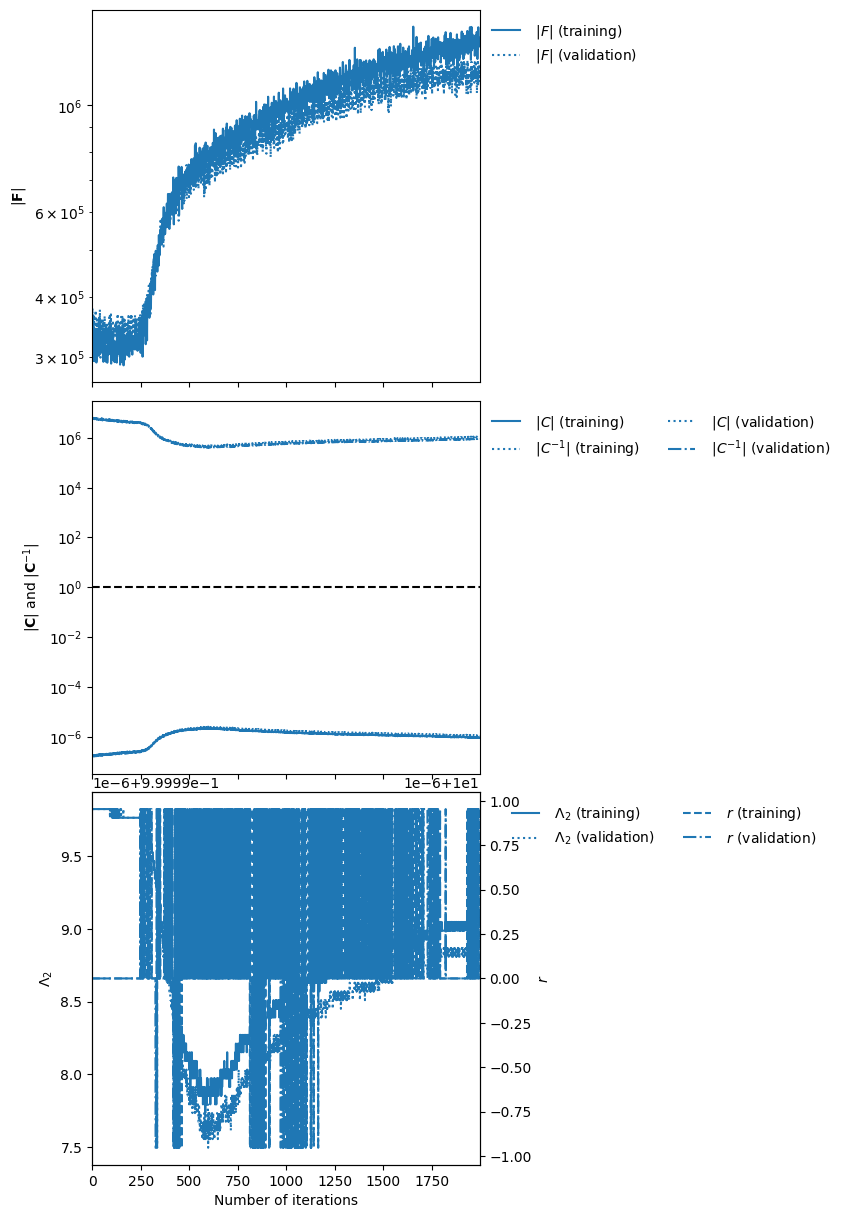

In [22]:
ax = IMNN.plot(expected_detF=None)
ax[0].set_yscale("log")

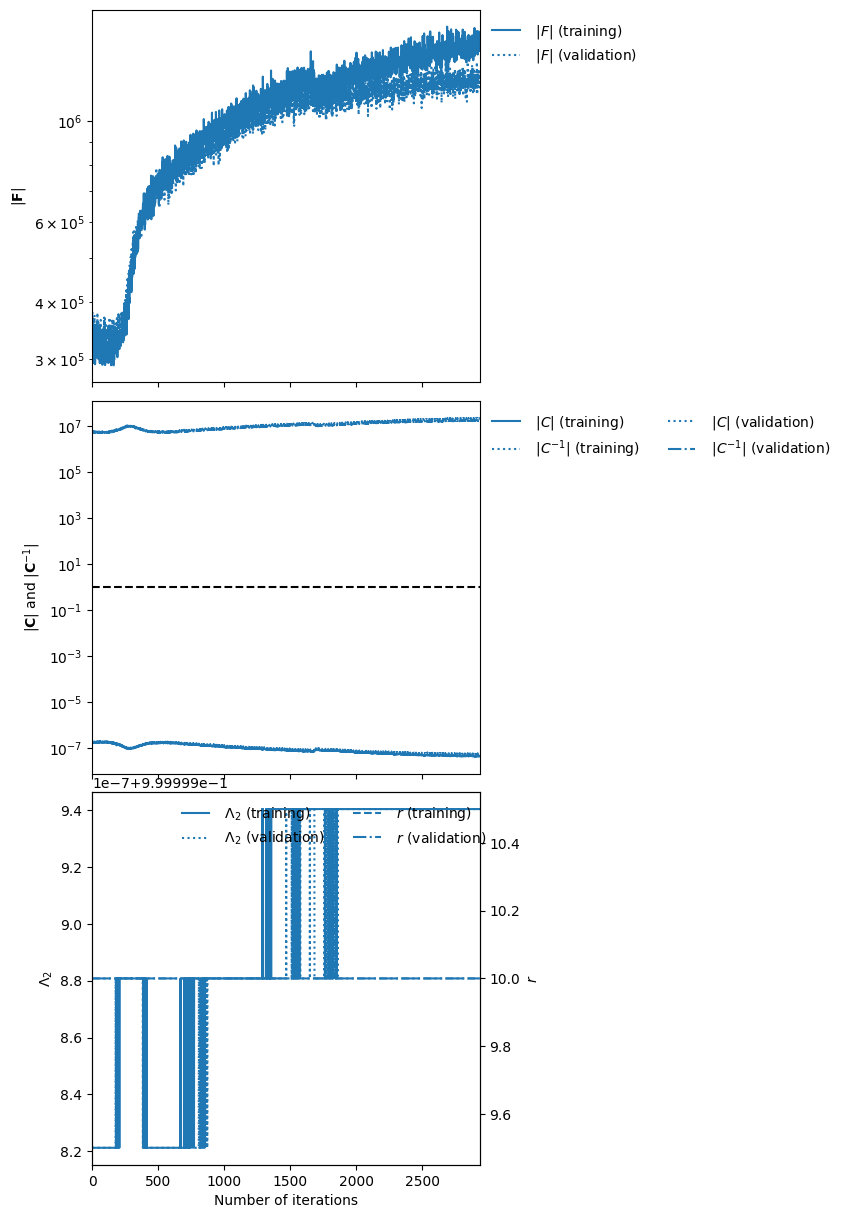

In [354]:
ax = IMNN.plot(expected_detF=None)
ax[0].set_yscale("log")

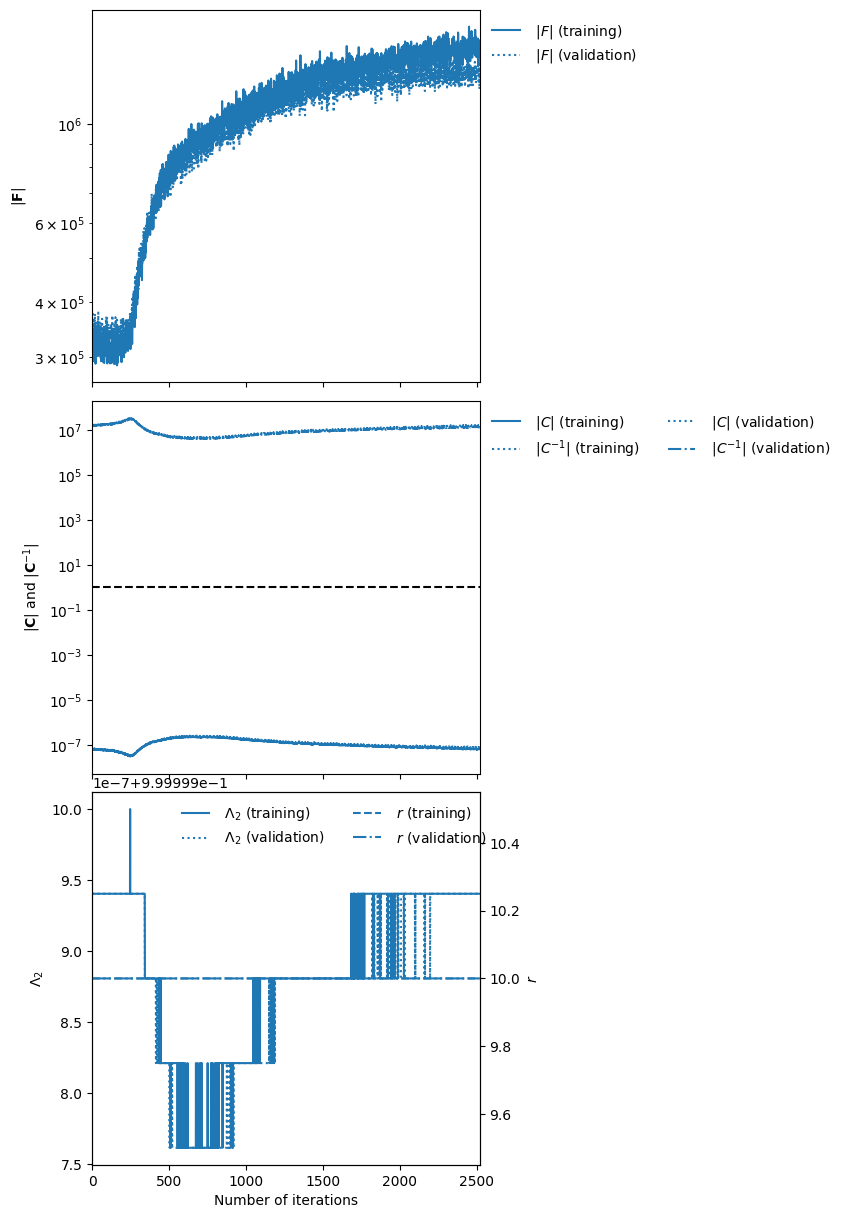

In [260]:
ax = IMNN.plot(expected_detF=None)
ax[0].set_yscale("log")

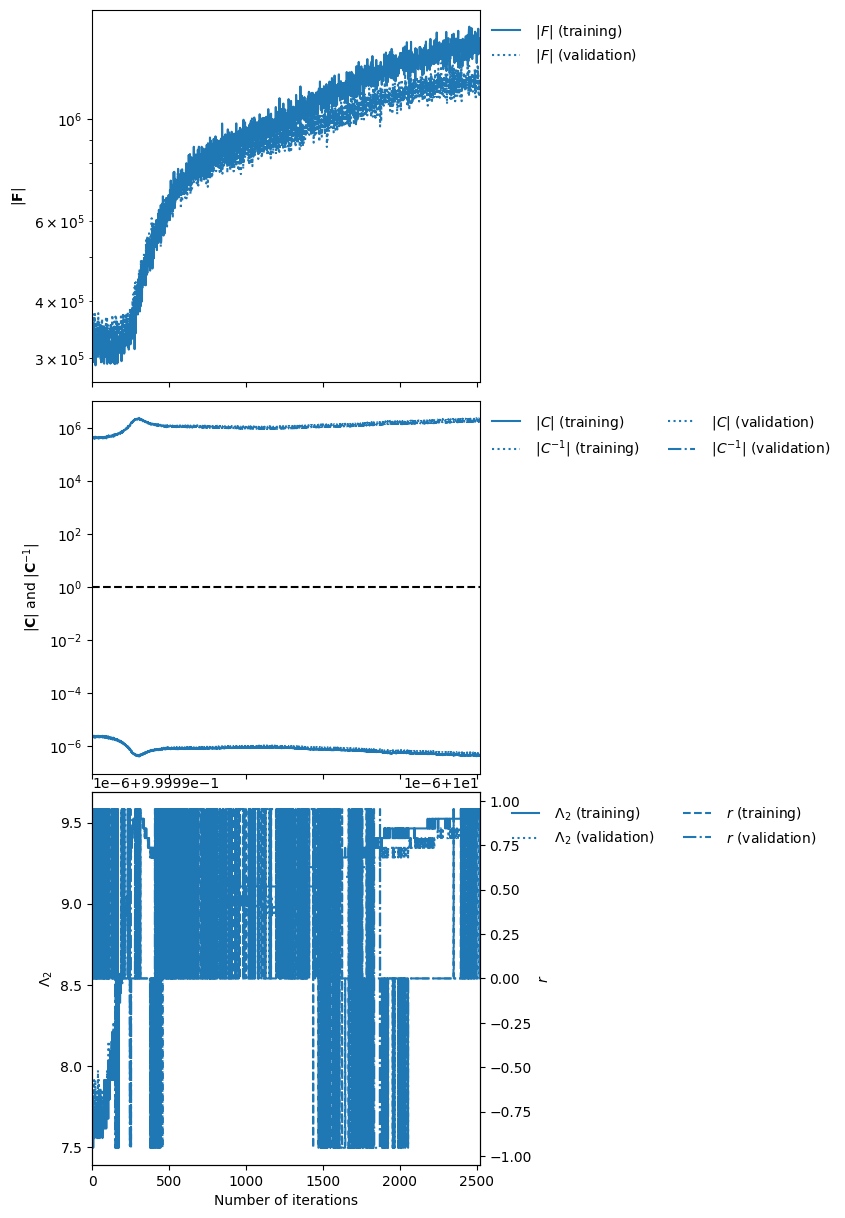

In [110]:
ax = IMNN.plot(expected_detF=None)
ax[0].set_yscale("log")

In [36]:
IMNN.F, mymoped.F

(Array([[3133.7085 ,  953.66895],
        [ 953.6688 ,  567.88416]], dtype=float32),
 Array([[2731.8271 ,  619.3432 ],
        [ 619.36334,  268.1493 ]], dtype=float32))

In [114]:
jnp.linalg.det(IMNN.F)

Array(1195754.5, dtype=float32)

In [115]:
jnp.linalg.det(IMNN.F) / jnp.linalg.det(mymoped.F)

Array(3.426829, dtype=float32)

In [145]:
w['params']['InceptStride_0']['Conv_0']['kernel'].shape

(2, 2, 4, 5)

In [144]:
IMNN.w['params']['InceptStride_0']['Conv_0']['kernel'].shape

(2, 2, 4, 5)

In [164]:
poo = (IMNN.w['params']['InceptStride_0']['Conv_2']['kernel'] - w['params']['InceptStride_0']['Conv_2']['kernel']) /  w['params']['InceptStride_0']['Conv_2']['kernel']

In [165]:
poo.mean(), poo.std(), poo.min(), poo.max()

(Array(0.09586413, dtype=float32),
 Array(3.2334201, dtype=float32),
 Array(-19.127993, dtype=float32),
 Array(20.419064, dtype=float32))

In [169]:
import sys
str(sys.getsizeof(IMNN.w['params']['InceptStride_0']['Conv_3']['kernel']))

'616'

In [24]:
#@title fisher code
import matplotlib.pyplot as plt
from matplotlib.patches import Ellipse

def plot_fisher_ellipse(fisher_matrix, mean=None, ax=None, color='blue', 
                        alpha=1.0, linestyle='-',
                       label=""):
    """
    Plots a Fisher information matrix ellipse.

    Parameters:
        fisher_matrix (numpy.ndarray): Fisher information matrix.
        mean (numpy.ndarray, optional): Mean vector. Defaults to None, in which case the ellipse will be centered at (0, 0).
        ax (matplotlib.axes.Axes, optional): Axes to plot on. If not provided, a new figure will be created.
        color (str, optional): Color of the ellipse. Defaults to 'blue'.
        alpha (float, optional): Transparency of the ellipse. Defaults to 0.5.
        linestyle (str, optional): Linestyle of the ellipse. Defaults to '-'.

    Returns:
        matplotlib.axes.Axes: Axes object with the ellipse plotted.
    """
    if ax is None:
        _, ax = plt.subplots()

    # Invert the Fisher information matrix to get the covariance matrix
    covariance_matrix = np.linalg.inv(fisher_matrix)

    # Calculate eigenvalues and eigenvectors of the covariance matrix
    eigenvalues, eigenvectors = np.linalg.eigh(covariance_matrix)
    order = eigenvalues.argsort()[::-1]
    eigenvalues = eigenvalues[order]
    eigenvectors = eigenvectors[:, order]

    # Calculate ellipse angle
    angle = np.degrees(np.arctan2(*eigenvectors[:, 0][::-1]))

    # If mean is provided, set the center of the ellipse accordingly
    if mean is not None:
        center = mean
    else:
        center = np.zeros_like(covariance_matrix.shape[0])

    # Create ellipse for 1-sigma contour
    ellipse = Ellipse(xy=center,
                      width=2 * np.sqrt(eigenvalues[0]),
                      height=2 * np.sqrt(eigenvalues[1]),
                      angle=angle,
                      edgecolor=color,
                      linestyle=linestyle,
                      facecolor='none',
                      alpha=alpha,
                      label=label)

    # Create ellipse for 2-sigma contour
    ellipse2 = Ellipse(xy=center,
                       width=2 * 2 * np.sqrt(eigenvalues[0]),
                       height=2 * 2 * np.sqrt(eigenvalues[1]),
                       angle=angle,
                       edgecolor=color,
                       linestyle=linestyle,
                       facecolor='none',
                       alpha=alpha)

    ax.add_patch(ellipse)
    ax.add_patch(ellipse2)
    #ax.set_aspect('equal', 'box')
    ax.autoscale()
    return ax

In [262]:
ell[:cl_cut]

Array([ 100.43279,  200.86559,  301.29837,  401.73117,  502.16397,
        602.5968 ,  703.02954,  803.46234,  903.89514, 1004.3279 ,
       1104.7607 , 1205.1936 , 1305.6262 , 1406.0591 , 1506.492  ,
       1606.9247 , 1707.3574 , 1807.7903 , 1908.2231 , 2008.6559 ,
       2109.0886 , 2209.5215 , 2309.954  , 2410.3872 , 2510.8198 ,
       2611.2524 , 2711.6855 , 2812.1182 , 2912.5508 , 3012.984  ,
       3113.4165 , 3213.8494 , 3314.2822 , 3414.7148 , 3515.148  ,
       3615.5806 , 3716.0132 , 3816.4463 , 3916.879  , 4017.3115 ,
       4117.7446 , 4218.1772 , 4318.6104 , 4419.043  , 4519.4756 ,
       4619.908  , 4720.3413 , 4820.774  , 4921.207  , 5021.6396 ,
       5122.0723 , 5222.5054 , 5322.938  , 5423.371  , 5523.8037 ,
       5624.2363 , 5724.669  , 5825.102  , 5925.5347 , 6025.968  ,
       6126.4004 , 6226.833  , 6327.2656 ], dtype=float32)

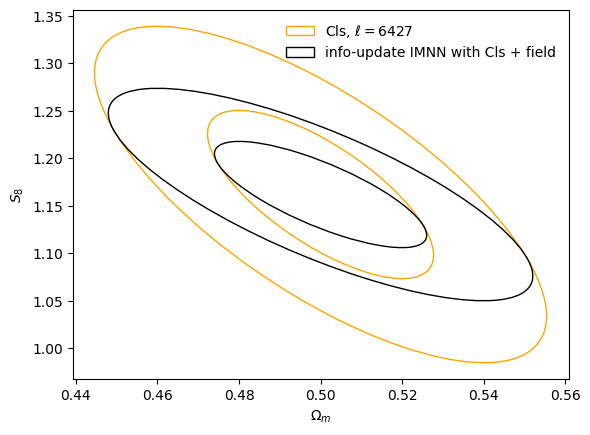

In [25]:
mean = θ_fid # Example mean vector

fishers = [mymoped.F, IMNN.F]
colours =["orange", "black", "blue"]
labels = [r"Cls, $\ell=%d$"%(ell[cl_cut]),  "info-update IMNN with Cls + field"]

for i,f in enumerate(fishers): 
    if i==0:
        ax = plot_fisher_ellipse(f, mean=mean, color=colours[i], label=labels[i])
    else:
        plot_fisher_ellipse(f, mean=mean, ax=ax, color=colours[i], label=labels[i])

plt.legend(framealpha=0.0)

plt.xlabel(r'$\Omega_m$')
plt.ylabel(r'$S_8$')
#plt.title('Fisher Information Matrix Ellipse')

#plt.grid(True)
plt.show()

In [115]:
L

250

In [326]:
save_obj(IMNN.w, outdir + "imnn_weights/NPE_stridenet_ell_2_filt_5_L_%d"%(L))

In [20]:
outdir

'/data101/makinen/lemur_sims/first_analysis/'

In [21]:
w = load_obj(outdir + "imnn_weights/weights_info_update_all_cls_S8_L_%d.pkl"%(L))

In [22]:
IMNN.set_F_statistics(w = w, key=jr.PRNGKey(0))

In [23]:
# [[17941.377 ,  3704.544 ],
#         [ 3704.5771,  7620.2715]]
IMNN.F

Array([[2937.2078,  829.9325],
       [ 829.9325,  461.7273]], dtype=float32)

In [24]:
#@title fisher code
import matplotlib.pyplot as plt
from matplotlib.patches import Ellipse

def plot_fisher_ellipse(fisher_matrix, mean=None, ax=None, color='blue', 
                        alpha=1.0, linestyle='-',
                       label=""):
    """
    Plots a Fisher information matrix ellipse.

    Parameters:
        fisher_matrix (numpy.ndarray): Fisher information matrix.
        mean (numpy.ndarray, optional): Mean vector. Defaults to None, in which case the ellipse will be centered at (0, 0).
        ax (matplotlib.axes.Axes, optional): Axes to plot on. If not provided, a new figure will be created.
        color (str, optional): Color of the ellipse. Defaults to 'blue'.
        alpha (float, optional): Transparency of the ellipse. Defaults to 0.5.
        linestyle (str, optional): Linestyle of the ellipse. Defaults to '-'.

    Returns:
        matplotlib.axes.Axes: Axes object with the ellipse plotted.
    """
    if ax is None:
        _, ax = plt.subplots()

    # Invert the Fisher information matrix to get the covariance matrix
    covariance_matrix = np.linalg.inv(fisher_matrix)

    # Calculate eigenvalues and eigenvectors of the covariance matrix
    eigenvalues, eigenvectors = np.linalg.eigh(covariance_matrix)
    order = eigenvalues.argsort()[::-1]
    eigenvalues = eigenvalues[order]
    eigenvectors = eigenvectors[:, order]

    # Calculate ellipse angle
    angle = np.degrees(np.arctan2(*eigenvectors[:, 0][::-1]))

    # If mean is provided, set the center of the ellipse accordingly
    if mean is not None:
        center = mean
    else:
        center = np.zeros_like(covariance_matrix.shape[0])

    # Create ellipse for 1-sigma contour
    ellipse = Ellipse(xy=center,
                      width=2 * np.sqrt(eigenvalues[0]),
                      height=2 * np.sqrt(eigenvalues[1]),
                      angle=angle,
                      edgecolor=color,
                      linestyle=linestyle,
                      facecolor='none',
                      alpha=alpha,
                      label=label)

    # Create ellipse for 2-sigma contour
    ellipse2 = Ellipse(xy=center,
                       width=2 * 2 * np.sqrt(eigenvalues[0]),
                       height=2 * 2 * np.sqrt(eigenvalues[1]),
                       angle=angle,
                       edgecolor=color,
                       linestyle=linestyle,
                       facecolor='none',
                       alpha=alpha)

    ax.add_patch(ellipse)
    ax.add_patch(ellipse2)
    #ax.set_aspect('equal', 'box')
    ax.autoscale()
    return ax

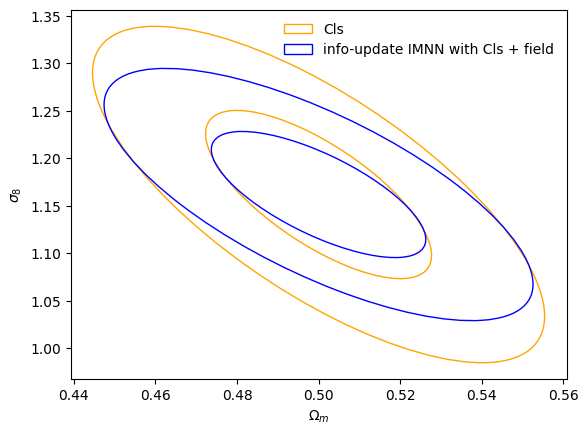

In [25]:
mean = θ_fid # Example mean vector

fishers = [mymoped.F, IMNN.F]
colours =["orange", "blue"]
labels = ["Cls", "info-update IMNN with Cls + field"]

for i,f in enumerate(fishers): 
    if i==0:
        ax = plot_fisher_ellipse(f, mean=mean, color=colours[i], label=labels[i])
    else:
        plot_fisher_ellipse(f, mean=mean, ax=ax, color=colours[i], label=labels[i])

plt.legend(framealpha=0.0)
plt.xlabel(r'$\Omega_m$')
plt.ylabel(r'$\sigma_8$')
plt.show()

In [27]:
L

250

In [296]:
# pull in prior 
num = 5000

# prior_sims = jnp.load(outdir + "prior_S8_L_250_N_128_Nz_512_LPT2.npz")["prior_sims"][:num]
# prior_theta = jnp.load(outdir + "prior_S8_L_250_N_128_Nz_512_LPT2.npz")["prior_theta"][:num]

prior_sims = jnp.load(outdir + "prior_new_S8_L_250_N_128_Nz_512_LPT2.npz")["prior_sims"][:num]
prior_theta = jnp.load(outdir + "prior_new_S8_L_250_N_128_Nz_512_LPT2.npz")["prior_theta"][:num]

def get_sigma8(omegam, S8):
    return S8 / (jnp.sqrt(omegam / 0.3))

def get_S8(theta):
    return np.array([theta[:, 0], theta[:, 1]*np.sqrt(theta[:, 0]/0.3)]).T


In [265]:
#prior_theta = get_S8(prior_theta)

In [297]:
key = jr.PRNGKey(333)
noisekeys = jr.split(key, num=prior_sims.shape[0])

# add in noise
prior_sims = jax.vmap(noise_simulator)(noisekeys, prior_sims)

In [298]:
# now compute Cls 

# ----- DO MOPED WITH ALL SIMS (NOISEFREE) -----
prior_cls = []
batch = 50
for i in tq(range(prior_sims.shape[0] // batch)):
    f_ = jax.vmap(cls_allbins_nonoise)(prior_sims[i*batch:(i+1)*batch]).reshape(-1, len(indices)*(num_bins))
    prior_cls.append(f_)

prior_cls = jnp.concatenate(prior_cls)













  0%|          | 0/100 [00:00<?, ?it/s]











  7%|▋         | 7/100 [00:00<00:01, 68.68it/s]











 15%|█▌        | 15/100 [00:00<00:01, 74.18it/s]











 23%|██▎       | 23/100 [00:00<00:01, 75.00it/s]











 31%|███       | 31/100 [00:00<00:00, 72.09it/s]











 39%|███▉      | 39/100 [00:00<00:00, 65.81it/s]











 47%|████▋     | 47/100 [00:00<00:00, 69.41it/s]











 55%|█████▌    | 55/100 [00:00<00:00, 71.60it/s]











 63%|██████▎   | 63/100 [00:00<00:00, 72.30it/s]











 71%|███████   | 71/100 [00:00<00:00, 72.55it/s]











 79%|███████▉  | 79/100 [00:01<00:00, 66.81it/s]











 87%|████████▋ | 87/100 [00:01<00:00, 69.72it/s]











100%|██████████| 100/100 [00:01<00:00, 71.27it/s][A


In [268]:
prior_cls.shape

(5000, 60)

In [299]:
# compress with moped to get Cls summaries
moped_summaries = mymoped.compress(prior_cls)

In [356]:
batch = 1000

outputs = jnp.concatenate([IMNN.get_estimate(prior_sims[i*batch:(i+1)*batch]) for i in range(prior_sims.shape[0] // batch)])

In [357]:
_appl = lambda d: IMNN.model(IMNN.w, d)

model_out_number = jnp.concatenate([jax.vmap(_appl)(prior_sims[i*batch:(i+1)*batch]) for i in range(prior_sims.shape[0] // batch)])


In [358]:
model_out_number.shape

(5000, 3)

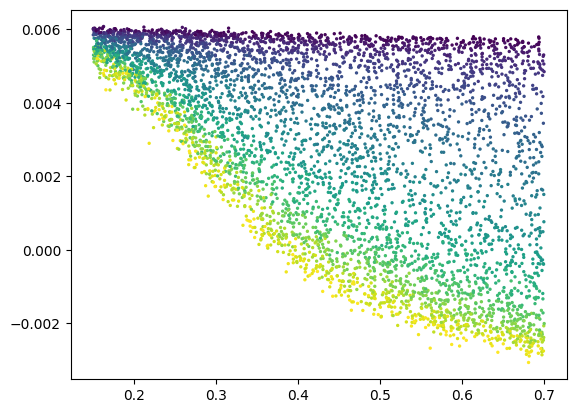

In [359]:
plt.scatter(prior_theta[:, 0], model_out_number[:, 2], s=2, c=prior_theta[:, 1])

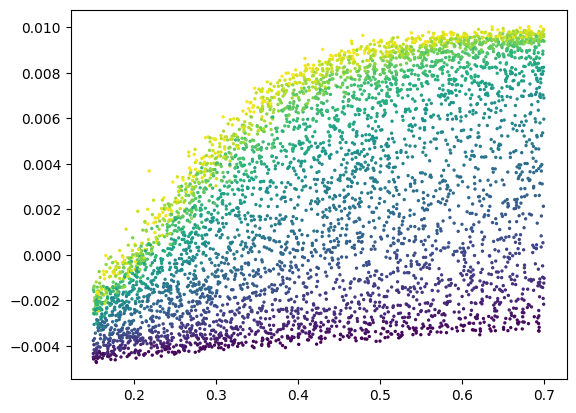

In [303]:
plt.scatter(prior_theta[:, 0], model_out_number[:, 2], s=2, c=prior_theta[:, 1])

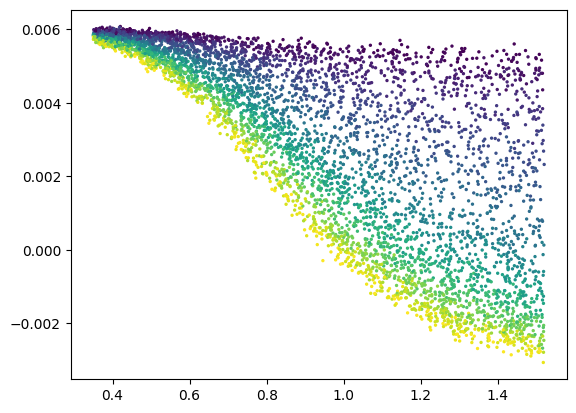

In [360]:
plt.scatter(prior_theta[:, 1], model_out_number[:, 2], s=2, c=prior_theta[:, 0])

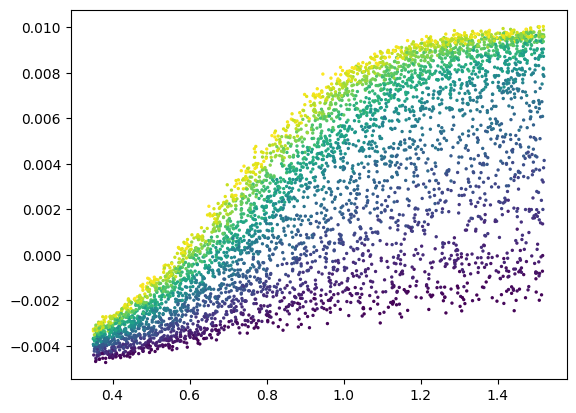

In [304]:
plt.scatter(prior_theta[:, 1], model_out_number[:, 2], s=2, c=prior_theta[:, 0])

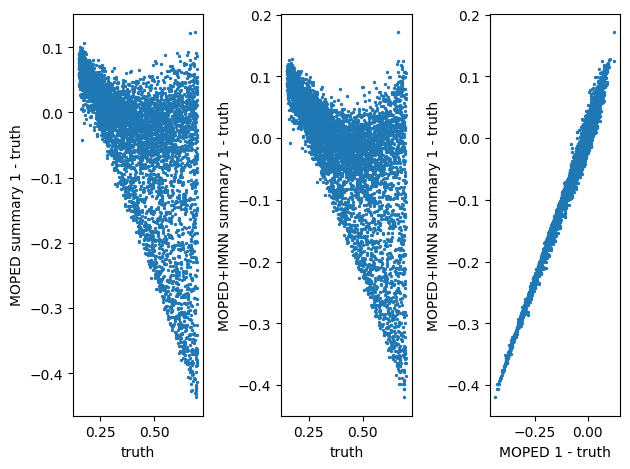

In [361]:
plt.subplot(131)
plt.scatter(prior_theta[:, 0], moped_summaries[:, 0] - prior_theta[:, 0], s=2)#, c=prior_theta[:, 1])
plt.xlabel(r"truth")
plt.ylabel(r"MOPED summary 1 - truth")

plt.subplot(132)
plt.scatter(prior_theta[:, 0], outputs[:, 0] - prior_theta[:, 0], s=2)
plt.ylabel(r"MOPED+IMNN summary 1 - truth")
plt.xlabel(r"truth")

plt.subplot(133)
plt.scatter((moped_summaries[:, 0] - prior_theta[:, 0]), outputs[:, 0] - prior_theta[:, 0], s=2)
plt.ylabel(r"MOPED+IMNN summary 1 - truth")
plt.xlabel(r"MOPED 1 - truth")

            
plt.tight_layout()

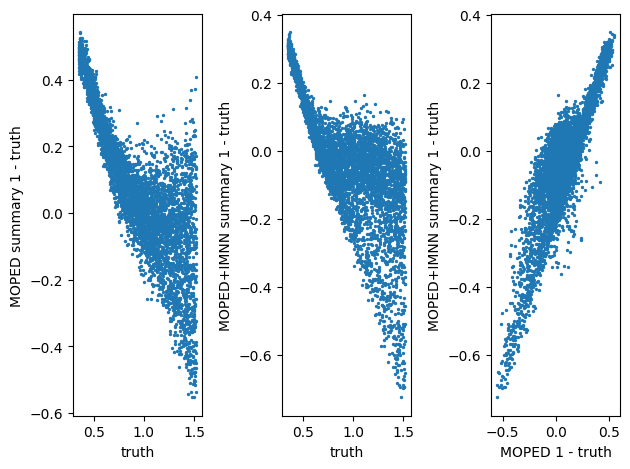

In [362]:
plt.subplot(131)
param = 1

plt.scatter(prior_theta[:, param], moped_summaries[:, param] - prior_theta[:, param], s=2)#, c=prior_theta[:, 1])
plt.xlabel(r"truth")
plt.ylabel(r"MOPED summary 1 - truth")

plt.subplot(132)
plt.scatter(prior_theta[:, param], outputs[:, param] - prior_theta[:, param], s=2)
plt.ylabel(r"MOPED+IMNN summary 1 - truth")
plt.xlabel(r"truth")

plt.subplot(133)
plt.scatter((moped_summaries[:, param] - prior_theta[:, param]), outputs[:, param] - prior_theta[:, param], s=2)
plt.ylabel(r"MOPED+IMNN summary 1 - truth")
plt.xlabel(r"MOPED 1 - truth")

            
plt.tight_layout()

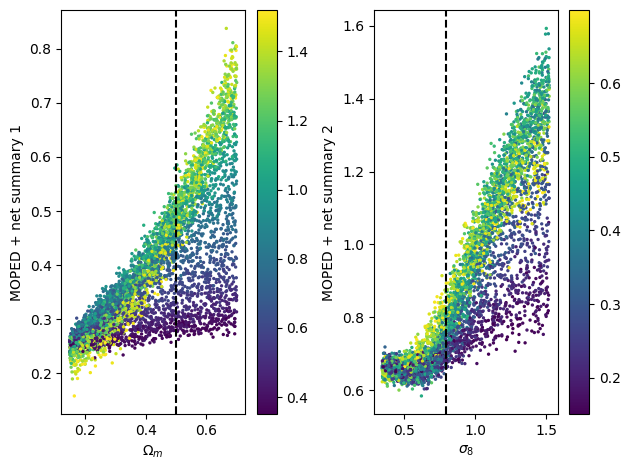

In [363]:
plt.subplot(121)
plt.scatter(prior_theta[:, 0], outputs[:, 0], s=2, c=prior_theta[:, 1])
plt.axvline(θ_fid[0], c="k", ls="--")
plt.xlabel(r"$\Omega_m$")
plt.ylabel(r"MOPED + net summary 1")
plt.colorbar()

plt.subplot(122)
plt.scatter(prior_theta[:, 1], outputs[:, 1], s=2, c=prior_theta[:, 0])
plt.axvline(0.8, c="k", ls="--")
plt.ylabel(r"MOPED + net summary 2")
plt.xlabel(r"$\sigma_8$")
plt.colorbar()

plt.tight_layout()

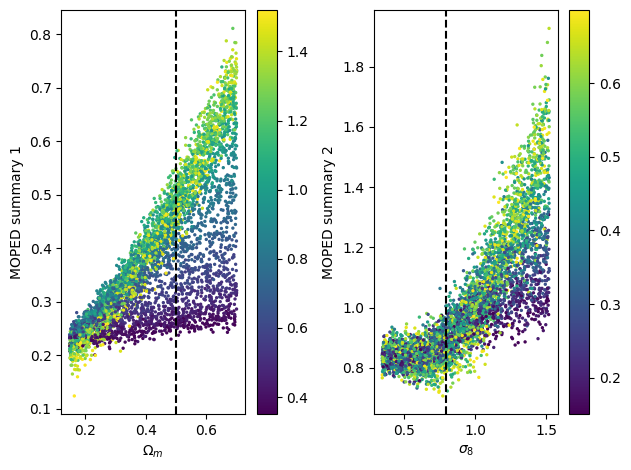

In [364]:
plt.subplot(121)
plt.scatter(prior_theta[:, 0], moped_summaries[:, 0], s=2, c=prior_theta[:, 1])
plt.axvline(θ_fid[0], c="k", ls="--")
plt.xlabel(r"$\Omega_m$")
plt.ylabel(r"MOPED summary 1")
plt.colorbar()

plt.subplot(122)
plt.scatter(prior_theta[:, 1], moped_summaries[:, 1], s=2, c=prior_theta[:, 0])
plt.axvline(0.8, c="k", ls="--")
plt.ylabel(r"MOPED summary 2")
plt.xlabel(r"$\sigma_8$")
plt.colorbar()

plt.tight_layout()

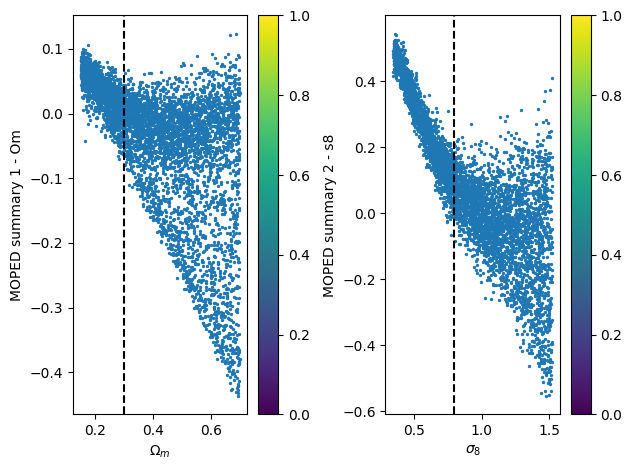

In [365]:
plt.subplot(121)
plt.scatter(prior_theta[:, 0], moped_summaries[:, 0] - prior_theta[:, 0], s=2)#, c=neural_summaries[:, 1])
plt.axvline(0.3, c="k", ls="--")

plt.xlabel(r"$\Omega_m$")
plt.ylabel(r"MOPED summary 1 - Om")
plt.colorbar()

plt.subplot(122)
plt.scatter(prior_theta[:, 1], moped_summaries[:, 1] - prior_theta[:, 1], s=2 )#, c=neural_summaries[:, 0])
plt.axvline(0.8, c="k", ls="--")
plt.ylabel(r"MOPED summary 2 - s8")
plt.xlabel(r"$\sigma_8$")
plt.colorbar()


plt.tight_layout()

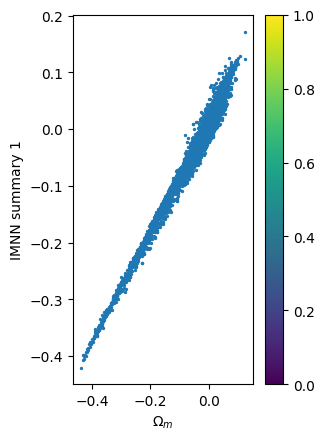

In [366]:
plt.subplot(121)
plt.scatter(moped_summaries[:, 0] - prior_theta[:, 0], outputs[:, 0] - prior_theta[:, 0], s=2)#, c=neural_summaries[:, 1])
#plt.axvline(0.3, c="k", ls="--")

plt.xlabel(r"$\Omega_m$")
plt.ylabel(r"IMNN summary 1")
plt.colorbar()

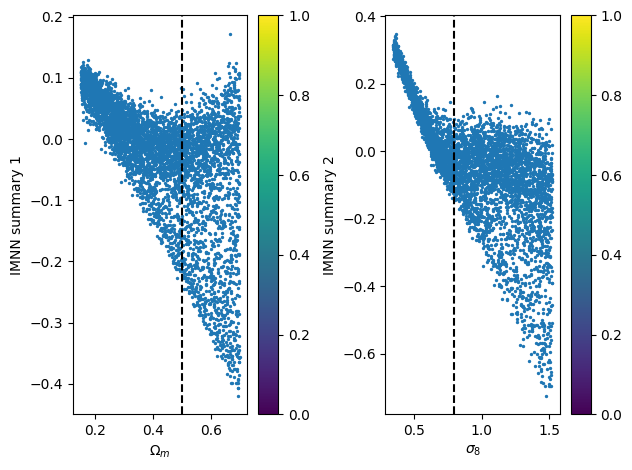

In [367]:
plt.subplot(121)
plt.scatter(prior_theta[:, 0], outputs[:, 0] - prior_theta[:, 0], s=2)#, c=neural_summaries[:, 1])
plt.axvline(0.5, c="k", ls="--")

plt.xlabel(r"$\Omega_m$")
plt.ylabel(r"IMNN summary 1")
plt.colorbar()

plt.subplot(122)
plt.scatter(prior_theta[:, 1], outputs[:, 1] - prior_theta[:, 1], s=2 )#, c=neural_summaries[:, 0])
plt.axvline(0.8, c="k", ls="--")
plt.ylabel(r"IMNN summary 2")
plt.xlabel(r"$\sigma_8$")
plt.colorbar()


plt.tight_layout()

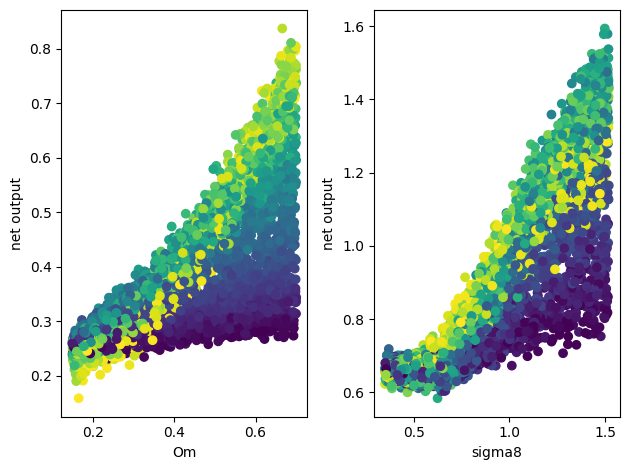

In [368]:
plt.subplot(121)
plt.scatter(prior_theta[:, 0], outputs[:, 0], c=prior_theta[:, 1])
plt.ylabel("net output")
plt.xlabel("Om")

plt.subplot(122)
plt.scatter(prior_theta[:, 1], outputs[:, 1], c=prior_theta[:, 0])
plt.ylabel("net output")
plt.xlabel("sigma8")
plt.tight_layout()

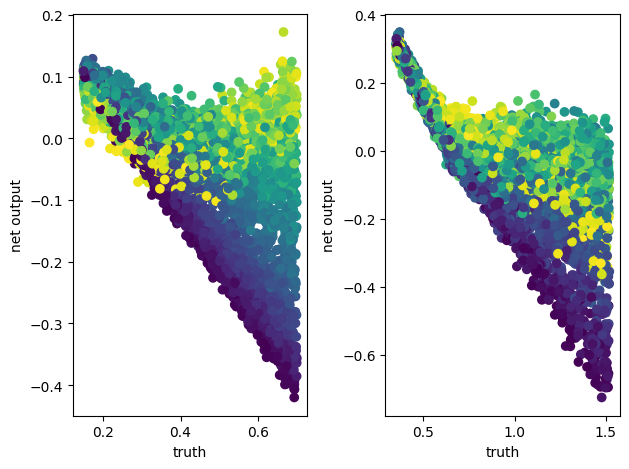

In [369]:
plt.subplot(121)
plt.scatter(prior_theta[:, 0], outputs[:, 0] - prior_theta[:, 0], c=prior_theta[:, 1])
plt.ylabel("net output")
plt.xlabel("truth")

plt.subplot(122)
plt.scatter(prior_theta[:, 1], outputs[:, 1] - prior_theta[:, 1], c=prior_theta[:, 0])
plt.ylabel("net output")
plt.xlabel("truth")
plt.tight_layout()

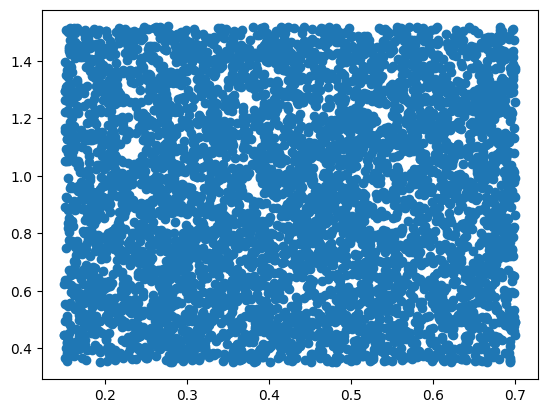

In [314]:
plt.scatter(prior_theta[:, 0], prior_theta[:, 1])

In [370]:
# SAVE EVERYTHING FOR DENSITY ESTIMATION !!

np.savez("S8_sbi_L250_npe_flatprior_ell1_2",
         moped_summaries=moped_summaries,
         #neural_summaries=neural_summaries,
         prior_theta=prior_theta,
         network_outputs=outputs,
         model_out_number=model_out_number
        )

In [103]:
outputs.shape

(5000, 2)

In [54]:
prior_theta.shape, outputs.shape, moped_summaries.shape

((5000, 2), (5000, 2), (5000, 2))